In [4]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import os
import argparse

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\rfgla\Documents\Ray\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
import torch
import pytorch_lightning as pl
from torchvision.io import read_video, read_video_timestamps
import sys
sys.path.append(r'C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master')
from videogpt import download, VQVAE, VideoGPT
from videogpt.data import VideoData
from videogpt.data import preprocess
from convolutional_classifier import Classifier as ConvolutionalClassifier
from testing_functions import plot_confusion_matrix

In [5]:
# Create arg parser
vqvae_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master\lightning_logs\version_23\checkpoints\epoch=60-step=188489.ckpt"
data_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\data\gesture_sorted_data"
config = {
        "--batch_size": 1,
        "--vqvae": vqvae_path,
        "--kernel_size": 3,
        "--out_channels": 3,
        "--n_classes": 8,
        "--lr": 8e-4,
        "--gpus": 1,
        "--data_path": data_path,
    }

parser = argparse.ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser.add_argument('--data_path', type=str, default='/home/wilson/data/datasets/bair.hdf5')
parser.add_argument('--sequence_length', type=int, default=16)
parser.add_argument('--resolution', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=8)
parser = ConvolutionalClassifier.add_model_specific_args(parser)
config_args = []
for key in config.keys():
        config_args.append(key)
        config_args.append(str(config[key]))
args = parser.parse_args(config_args)

In [6]:
# Create data loader
data = VideoData(args)
test_loader = data.test_dataloader()
args.n_classes = data.n_classes

In [7]:
# Load classifier from checkpoint
classifier_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\convolutional_classifier\checkpoint_61.ckpt"
device = torch.device('cuda')
model = ConvolutionalClassifier(args)
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=args.lr)

checkpoint = torch.load(classifier_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
model.eval()

Classifier(
  (vqvae): VQVAE(
    (encoder): Encoder(
      (convs): ModuleList(
        (0): SamePadConv3d(
          (conv): Conv3d(3, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (1): SamePadConv3d(
          (conv): Conv3d(240, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
      )
      (conv_last): SamePadConv3d(
        (conv): Conv3d(240, 240, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (res_stack): Sequential(
        (0): AttentionResidualBlock(
          (block): Sequential(
            (0): BatchNorm3d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): SamePadConv3d(
              (conv): Conv3d(240, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
            )
            (3): BatchNorm3d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): SamePadConv3d(
              (conv): Conv3d(120, 240, kernel_size=(1, 1

In [45]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    # n must not be 0
    for i in range(0, len(lst), n):
        if i + n >= len(lst):
            yield lst[-n:]
        else:
            yield lst[i:i + n]

In [71]:
def chunks_by_overlap(lst, overlap, n):
    for i in range(0, len(lst) - n + 1, overlap):
        if i + n >= len(lst):
            yield lst[-n:], [len(lst)-n, len(lst)]
        else:
            yield lst[i:i + n], [i, i + n]

In [88]:
# Go through test folder videos
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
correct = 0
count = 0
confusion_matrix = np.zeros([args.n_classes, args.n_classes])
for this_group in os.listdir(os.path.join(data_path, 'test')):
    group_path = os.path.join(data_path, 'test', this_group)
    if not os.path.isdir(group_path):
        continue
    gt_label = groups.index(this_group)
    for this_video in os.listdir(group_path):
        if not os.path.splitext(this_video)[1] == '.mp4':
            continue
        video_filename = os.path.join(group_path, this_video)
        resolution, sequence_length = model.args.resolution, 16
        pts = read_video_timestamps(video_filename, pts_unit='sec')[0]
        video = read_video(video_filename, pts_unit='sec', start_pts=pts[0])[0]

        overlap_size = 4  # number of frames for clips to overlap
        n_clips = video.shape[0] // sequence_length + 1

        # Get clips of certain overlap
        clips = chunks_by_overlap(video, overlap_size, sequence_length)

        # Get the minimal number of clips that covers the entire video
        # clips = chunks(video, sequence_length)

        pred_labels = []  # store predicted labels for each clip
        pred_probs = []  # store predicted probabilities in the case of a tie
        for video_clip, bounds in clips:
            video_clip = preprocess(video_clip, resolution, sequence_length).unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = model(video_clip)
                pred_probs.append(predictions)
                pred_labels.append(predictions.argmax(axis=1))

        labels, counts = np.unique(torch.asarray(pred_labels).cpu().numpy(), return_counts=True)
        pred_probs = [i.cpu().numpy() for i in pred_probs]
        best_label = None
        best_count = 0
        for this_label in labels:
            this_count = counts[np.where(labels == this_label)][0]
            take_this_label = False
            if best_label is None:
                take_this_label = True
            else:
                if this_count > best_count:
                    take_this_label = True
                elif this_count == best_count:
                    mean_probs = np.mean(pred_probs, axis=0)[0]
                    if mean_probs[this_label] > mean_probs[best_label]:
                        take_this_label = True
            if take_this_label:
                best_label = this_label
                best_count = this_count

        result = best_label == gt_label
        correct += result.sum().item()
        count += 1
        confusion_matrix[gt_label][best_label] += 1


In [89]:
accuracy = correct / count
print(accuracy)
acc_matrix = confusion_matrix / np.max(confusion_matrix, axis=0)
print(confusion_matrix)
print(acc_matrix)

0.75
[[ 9.  2.  1.  2.  0.  2.  2.  1.  3.]
 [ 3. 12.  0.  1.  0.  0.  0.  2.  1.]
 [ 0.  0. 19.  0.  0.  2.  0.  0.  0.]
 [ 2.  1.  0. 10.  1.  0.  6.  0.  0.]
 [ 0.  0.  0.  0. 20.  1.  0.  0.  0.]
 [ 2.  0.  6.  0.  0. 23.  0.  0.  0.]
 [ 0.  1.  0.  2.  1.  0. 12.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. 23.  1.]
 [ 0.  1.  0.  0.  0.  1.  0.  1. 22.]]
[[1.         0.16666667 0.05263158 0.2        0.         0.08695652
  0.16666667 0.04347826 0.13636364]
 [0.33333333 1.         0.         0.1        0.         0.
  0.         0.08695652 0.04545455]
 [0.         0.         1.         0.         0.         0.08695652
  0.         0.         0.        ]
 [0.22222222 0.08333333 0.         1.         0.05       0.
  0.5        0.         0.        ]
 [0.         0.         0.         0.         1.         0.04347826
  0.         0.         0.        ]
 [0.22222222 0.         0.31578947 0.         0.         1.
  0.         0.         0.        ]
 [0.         0.08333333 0.         0.2     

True

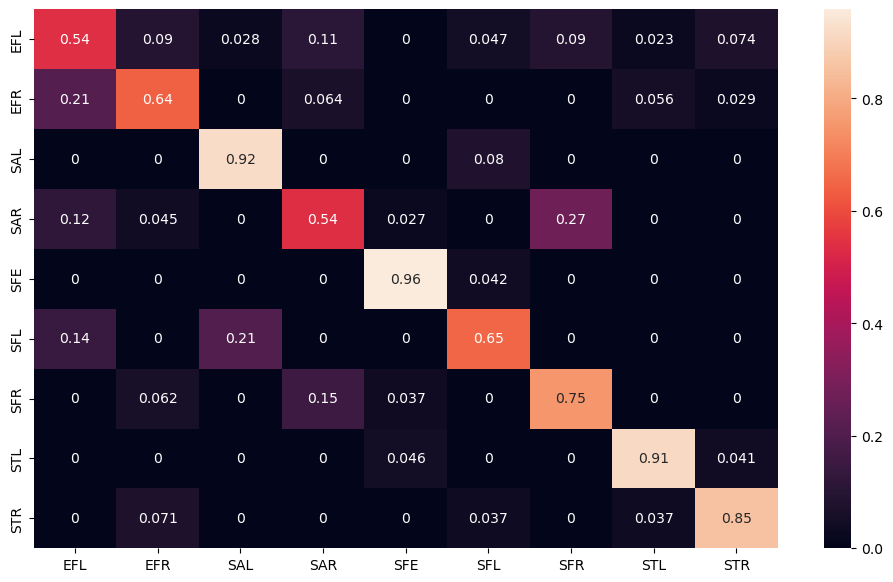

In [90]:
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
plot_confusion_matrix(acc_matrix, groups)